In [ ]:
import os, tarfile, pathlib

ARCHIVE = "cv-corpus-11.0-2022-09-21-en.tar.gz"
OUT_DIR = "data/cv11_en"
os.makedirs(OUT_DIR, exist_ok=True)

want = [
    "cv-corpus-11.0-2022-09-21/en/validated.tsv",
    "cv-corpus-11.0-2022-09-21/en/dev.tsv",
    "cv-corpus-11.0-2022-09-21/en/test.tsv",
    "cv-corpus-11.0-2022-09-21/en/train.tsv",
    "cv-corpus-11.0-2022-09-21/en/clips"
]

with tarfile.open(ARCHIVE, "r:gz") as tf:
    for m in tf.getmembers():
        if any(m.name.startswith(w) for w in want):
            tf.extract(m, OUT_DIR)

print("Done. Extracted into:", pathlib.Path(OUT_DIR).resolve())

In [ ]:
import os

DATA_DIR = "/Users/ninadjoshi/asr-comparative-study/ASR-Comparative-Study-Thesis/asr-comparative-study/notebooks/data/cv11_en"
print(os.listdir(DATA_DIR))

In [1]:
import os
print(os.getcwd())

/Users/ninadjoshi/asr-comparative-study/ASR-Comparative-Study-Thesis/asr-comparative-study/notebooks


In [2]:
from pathlib import Path
import os, pandas as pd

# 1) Pointing  to the folder where you extracted the archive
DATA_DIR = Path("/Users/ninadjoshi/asr-comparative-study/ASR-Comparative-Study-Thesis/asr-comparative-study/notebooks/data/cv11_en")

# 2) Build the Common Voice root (version + language)
CV_VERSION = "cv-corpus-11.0-2022-09-21"
LANG = "en"
CV_ROOT = DATA_DIR / CV_VERSION / LANG
CLIPS_DIR = CV_ROOT / "clips"

print("CV_ROOT:", CV_ROOT)
print("Exists?", CV_ROOT.exists())
print("Files:", list(CV_ROOT.glob("*.tsv"))[:5])

# 3) Reading the splits (TSV, tab-delimited)
meta = pd.read_csv(CV_ROOT / "validated.tsv", sep="\t")
# or choose 'dev.tsv' / 'test.tsv' / 'train.tsv'

# 4) Adding absolute audio paths
meta["audio_path"] = meta["path"].apply(lambda p: str(CLIPS_DIR / p))

# quick sanity check
print(meta.head(3)[["path", "sentence", "audio_path"]])
print("Clip exists?", os.path.exists(meta.loc[0, "audio_path"]))

CV_ROOT: /Users/ninadjoshi/asr-comparative-study/ASR-Comparative-Study-Thesis/asr-comparative-study/notebooks/data/cv11_en/cv-corpus-11.0-2022-09-21/en
Exists? True
Files: [PosixPath('/Users/ninadjoshi/asr-comparative-study/ASR-Comparative-Study-Thesis/asr-comparative-study/notebooks/data/cv11_en/cv-corpus-11.0-2022-09-21/en/train.tsv'), PosixPath('/Users/ninadjoshi/asr-comparative-study/ASR-Comparative-Study-Thesis/asr-comparative-study/notebooks/data/cv11_en/cv-corpus-11.0-2022-09-21/en/dev.tsv'), PosixPath('/Users/ninadjoshi/asr-comparative-study/ASR-Comparative-Study-Thesis/asr-comparative-study/notebooks/data/cv11_en/cv-corpus-11.0-2022-09-21/en/validated.tsv'), PosixPath('/Users/ninadjoshi/asr-comparative-study/ASR-Comparative-Study-Thesis/asr-comparative-study/notebooks/data/cv11_en/cv-corpus-11.0-2022-09-21/en/test.tsv')]
                           path  \
0  common_voice_en_27710027.mp3   
1    common_voice_en_699711.mp3   
2  common_voice_en_21953345.mp3   

                 

In [3]:
small = meta.sample(200, random_state=0).reset_index(drop=True)

In [4]:
import soundfile as sf

def load_batch(batch):
    audio, sr = sf.read(batch["audio_path"])
    return {
        "audio": audio,
        "sampling_rate": sr,
        "sentence": batch["sentence"]
    }

In [5]:
# Slicing a manageable sample for now (e.g. 5k examples)
sample = meta.sample(5000, random_state=42).reset_index(drop=True)

In [6]:
import soundfile as sf

def load_batch(batch):
    audio, sr = sf.read(batch["audio_path"])
    return {
        "audio": audio,
        "sampling_rate": sr,
        "sentence": batch["sentence"]
    }

In [7]:
import numpy as np
import soundfile as sf
import librosa 

def load_audio(path):
    """Read audio as float32 in [-1, 1] and return (wave, sr)."""
    audio, sr = sf.read(path, always_2d=False)
    # Ensure float32
    if audio.dtype != np.float32:
        audio = audio.astype(np.float32, copy=False)
    return audio, sr

def to_mono(wave):
    """Collapse multi-channel to mono."""
    if wave.ndim == 1:
        return wave
    # soundfile returns shape (n_samples, n_channels) sometimes; handle both
    if wave.shape[0] < wave.shape[-1]:  # (channels, samples)
        wave = wave.T
    return librosa.to_mono(wave.T).astype(np.float32)

def resample(wave, sr, target_sr):
    """Resample to target_sr using librosa."""
    if sr == target_sr:
        return wave
    wave = to_mono(wave)
    return librosa.resample(wave, orig_sr=sr, target_sr=target_sr).astype(np.float32)

In [8]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

WHISPER_ID = "openai/whisper-small"  # or "medium", "base", etc.
wh_proc  = WhisperProcessor.from_pretrained(WHISPER_ID)
wh_model = WhisperForConditionalGeneration.from_pretrained(WHISPER_ID).to(device).eval()
WHISPER_SR = wh_proc.feature_extractor.sampling_rate  # typically 16000

GEN_KW = dict(task="transcribe", language="en", num_beams=3, length_penalty=1.0,
              no_repeat_ngram_size=3, temperature=0.0)

def transcribe_whisper_path(path):
    wave, sr = load_audio(path)
    wave16 = resample(wave, sr, WHISPER_SR)
    inputs = wh_proc(wave16, sampling_rate=WHISPER_SR, return_tensors="pt").to(device)
    with torch.no_grad():
        ids = wh_model.generate(inputs.input_features, **GEN_KW)
    text = wh_proc.batch_decode(ids, skip_special_tokens=True)[0]
    return text

In [9]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

W2V_ID   = "facebook/wav2vec2-large-960h-lv60-self"
w2v_proc = Wav2Vec2Processor.from_pretrained(W2V_ID)
w2v_model= Wav2Vec2ForCTC.from_pretrained(W2V_ID).to(device).eval()
W2V_SR   = w2v_proc.feature_extractor.sampling_rate  # typically 16000

def transcribe_w2v_path(path):
    wave, sr = load_audio(path)
    wave16 = resample(wave, sr, W2V_SR)
    inputs = w2v_proc(wave16, sampling_rate=W2V_SR, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        logits   = w2v_model(**inputs).logits
        pred_ids = torch.argmax(logits, dim=-1)
    text = w2v_proc.batch_decode(pred_ids, skip_special_tokens=True)[0]
    return text

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# from jiwer import wer, cer

#references = sample["sentence"].tolist()

#hyp_whisper = []
#hyp_w2v     = []

#for _, row in sample.iterrows():
    #path = row["audio_path"]
    #hyp_whisper.append(transcribe_whisper_path(path))
    #hyp_w2v.append(transcribe_w2v_path(path))

#print(f"Whisper  WER: {wer(references, hyp_whisper)*100:.2f}% | CER: {cer(references, hyp_whisper)*100:.2f}%")
#print(f"Wav2Vec2 WER: {wer(references, hyp_w2v)*100:.2f}% | CER: {cer(references, hyp_w2v)*100:.2f}%")

In [10]:
!pip -q install soundfile jiwer transformers==4.* librosa

zsh:1: no matches found: transformers==4.*


In [11]:
import os, time, json, math, numpy as np, pandas as pd
import torch, soundfile as sf, librosa
from jiwer import wer, cer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Fast duration without loading whole file into memory
def get_duration_sec(path: str) -> float:
    with sf.SoundFile(path) as f:
        return len(f) / f.samplerate

# Load + resample mono audio to target SR (float32)
def load_mono_resampled(path: str, target_sr: int) -> np.ndarray:
    wav, sr = sf.read(path, always_2d=False)        # np.float32/64
    if wav.ndim > 1:                                # mixdown
        wav = wav.mean(axis=1)
    if sr != target_sr:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)
    return wav.astype("float32")

Device: cpu


In [12]:
N = 50  # start small; scale up later
sample_small = sample.sample(N, random_state=0).reset_index(drop=True)

refs  = sample_small["sentence"].tolist()
paths = sample_small["audio_path"].tolist()
print(f"Subset: {len(paths)} clips | First file: {paths[0]}")


Subset: 50 clips | First file: /Users/ninadjoshi/asr-comparative-study/ASR-Comparative-Study-Thesis/asr-comparative-study/notebooks/data/cv11_en/cv-corpus-11.0-2022-09-21/en/clips/common_voice_en_69651.mp3


In [13]:
from transformers import pipeline, Wav2Vec2Processor, Wav2Vec2ForCTC

# --- Whisper (use 'small' for speed or 'medium' for quality) ---
WHISPER_ID = "openai/whisper-medium"   # change to "openai/whisper-small" if needed
wh_asr = pipeline(
    "automatic-speech-recognition",
    model=WHISPER_ID,
    device=0 if torch.cuda.is_available() else -1,        # pipeline handles CPU/GPU
    generate_kwargs=dict(task="transcribe", language="en", num_beams=5, temperature=0.0)
)

# --- Wav2Vec2 (16 kHz) ---
W2V_ID  = "facebook/wav2vec2-large-960h-lv60-self"
W2V_SR  = 16000
w2v_proc  = Wav2Vec2Processor.from_pretrained(W2V_ID)
w2v_model = Wav2Vec2ForCTC.from_pretrained(W2V_ID).to(device).eval()


Device set to use cpu
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Whisper via pipeline (batch)
def transcribe_whisper_paths(paths, batch_size=8):
    outs = wh_asr(paths, batch_size=batch_size)
    # pipeline returns list[{"text": "..."}]
    return [o["text"].lower().strip() for o in outs]

# Wav2Vec2 batched
def transcribe_w2v_batch(paths, batch_size=16, target_sr=W2V_SR):
    hyps = []
    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i+batch_size]
        wavs = [load_mono_resampled(p, target_sr) for p in batch_paths]
        inputs = w2v_proc(
            wavs, sampling_rate=target_sr, return_tensors="pt", padding=True
        ).to(device)
        with torch.no_grad():
            logits = w2v_model(**inputs).logits
            pred_ids = torch.argmax(logits, dim=-1)
        texts = w2v_proc.batch_decode(pred_ids, skip_special_tokens=True)
        hyps.extend([t.lower().strip() for t in texts])
    return hyps

In [15]:
# Total audio seconds (for RTF)
audio_seconds_total = sum(get_duration_sec(p) for p in paths)

# --- Whisper ---
t0 = time.time()
hyp_whisper = transcribe_whisper_paths(paths, batch_size=8)
wh_wall = time.time() - t0
wh_rtf  = wh_wall / audio_seconds_total

# --- Wav2Vec2 ---
t0 = time.time()
hyp_w2v = transcribe_w2v_batch(paths, batch_size=16)
w2v_wall = time.time() - t0
w2v_rtf  = w2v_wall / audio_seconds_total

# Metrics
wh_wer  = wer(refs, hyp_whisper) * 100
wh_cer  = cer(refs, hyp_whisper) * 100
w2v_wer = wer(refs, hyp_w2v) * 100
w2v_cer = cer(refs, hyp_w2v) * 100

print(f"[Whisper]  WER: {wh_wer:.2f}%  CER: {wh_cer:.2f}%  | wall: {wh_wall:.1f}s  RTF: {wh_rtf:.3f}")
print(f"[Wav2Vec2] WER: {w2v_wer:.2f}%  CER: {w2v_cer:.2f}% | wall: {w2v_wall:.1f}s RTF: {w2v_rtf:.3f}")

`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.
python(66922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[Whisper]  WER: 23.23%  CER: 5.72%  | wall: 5688.9s  RTF: 23.171
[Wav2Vec2] WER: 39.14%  CER: 9.63% | wall: 32.5s RTF: 0.132


In [16]:
os.makedirs("runs", exist_ok=True)

df_out = pd.DataFrame({
    "path": paths,
    "ref": refs,
    "whisper": hyp_whisper,
    "wav2vec2": hyp_w2v,
})
ts = time.strftime("%Y%m%d-%H%M%S")
csv_path  = f"runs/cv11_subset_{len(paths)}_{ts}.csv"
json_path = f"runs/cv11_subset_{len(paths)}_{ts}.json"

df_out.to_csv(csv_path, index=False)

run = dict(
    dataset="Common Voice 11 (subset)",
    n_items=len(paths),
    audio_s=audio_seconds_total,
    whisper=dict(model=WHISPER_ID, WER=wh_wer, CER=wh_cer, wall_s=wh_wall, RTF=wh_rtf),
    wav2vec2=dict(model=W2V_ID, WER=w2v_wer, CER=w2v_cer, wall_s=w2v_wall, RTF=w2v_rtf),
)

with open(json_path, "w") as f:
    json.dump(run, f, indent=2)

print(f"Saved:\n- {csv_path}\n- {json_path}")

Saved:
- runs/cv11_subset_50_20250905-084801.csv
- runs/cv11_subset_50_20250905-084801.json


## Graphical presentation of the results 

,model,WER,CER,wall_s,RTF,items
0,Whisper,23.225806,5.724907,5688.880412,23.170930,50
1,Wav2Vec2,39.139785,9.628253,32.520292,0.132456,50


,i,ref,hyp_whisper,hyp_w2v,WER_w,CER_w,MER_w,WIL_w,WIP_w,WER_v,CER_v,MER_v,WIL_v,WIP_v
0,0,And what's the matter with a thousand dollars?,and what's the matter with a thousand dollars?,and what's the mater with a thousand dolars,12.500000,2.173913,12.500000,23.437500,76.562500,37.500000,8.695652,37.500000,60.937500,39.062500
1,1,Bedoya's line has become widely imitated by en...,bidoya's line has become widely imitated by en...,bidoe's line has become widely imitated by ent...,12.500000,3.508772,12.500000,23.437500,76.562500,25.000000,8.771930,25.000000,43.750000,56.250000
2,2,"An hour later, he had before him a chest of Sp...",an hour later he had before him a chest of spa...,an hour later he had before him a chest of spa...,23.076923,4.761905,23.076923,40.828402,59.171598,30.769231,6.349206,30.769231,52.071006,47.928994
3,3,"Ladies and gentlemen, this is your captain spe...","ladies and gentlemen, this is your captain spe...",ladies and gentlemen this is your captain spea...,12.500000,1.923077,12.500000,23.437500,76.562500,37.500000,5.769231,37.500000,60.937500,39.062500
4,4,Alastair McDonald also sang a song about trams...,alastair macdonald also sang a song about tram...,elister macdonald also sang a song about trams...,30.769231,17.105263,28.571429,45.054945,54.945055,30.769231,21.052632,28.571429,45.054945,54.945055


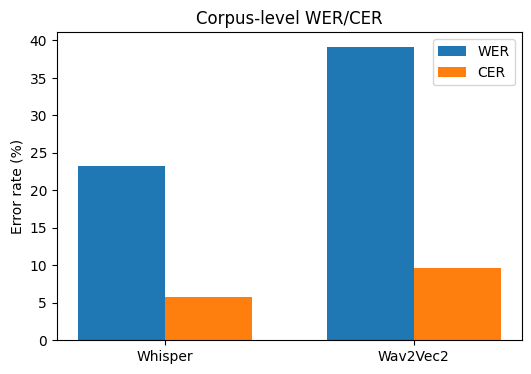

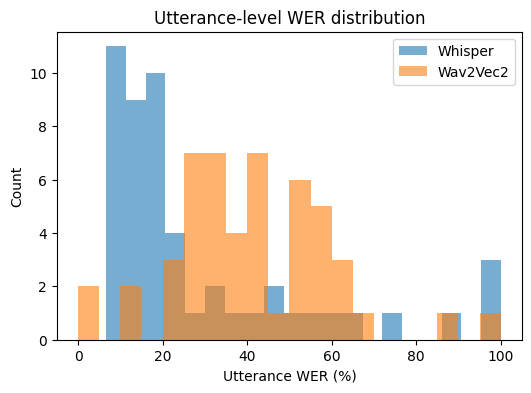

Whisper: wall=5688.9s  RTF=23.171 | Wav2Vec2: wall=32.5s  RTF=0.132
Saved: runs/model_summary.csv and runs/utterance_measures.csv


In [18]:
# --- Imports & a small compatibility shim ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jiwer import wer, cer, mer, wil, wip   # public functions

def compute_measures_compat(truth, hyp):
    """
    Replacement for jiwer.compute_measures.
    Returns the same keys + CER for convenience.
    Values are FRACTIONS (0..1) to stay consistent with jiwer.* functions.
    """
    return {
        "wer": wer(truth, hyp),
        "cer": cer(truth, hyp),
        "mer": mer(truth, hyp),
        "wil": wil(truth, hyp),
        "wip": wip(truth, hyp),
    }

# ---------- Model summary (one row per model) ----------
# Using the variable names.
summary = []

summary.append({
    "model": "Whisper",
    "WER": wer(refs, hyp_whisper)*100,
    "CER": cer(refs, hyp_whisper)*100,
    "wall_s": wh_wall,
    "RTF": wh_rtf,
    "items": len(refs),
})

summary.append({
    "model": "Wav2Vec2",
    "WER": wer(refs, hyp_w2v)*100,
    "CER": cer(refs, hyp_w2v)*100,
    "wall_s": w2v_wall,
    "RTF": w2v_rtf,
    "items": len(refs),
})

df_models = pd.DataFrame(summary)
display(df_models)

# ---------- Per-utterance table ----------
rows = []
for i, (r, h_w, h_v) in enumerate(zip(refs, hyp_whisper, hyp_w2v)):
    m_w = compute_measures_compat(r, h_w)
    m_v = compute_measures_compat(r, h_v)
    rows.append({
        "i": i,
        "ref": r,
        "hyp_whisper": h_w,
        "hyp_w2v": h_v,
        "WER_w": m_w["wer"]*100,
        "CER_w": m_w["cer"]*100,
        "MER_w": m_w["mer"]*100,
        "WIL_w": m_w["wil"]*100,
        "WIP_w": m_w["wip"]*100,
        "WER_v": m_v["wer"]*100,
        "CER_v": m_v["cer"]*100,
        "MER_v": m_v["mer"]*100,
        "WIL_v": m_v["wil"]*100,
        "WIP_v": m_v["wip"]*100,
    })

df_utts = pd.DataFrame(rows)

# Example previously built an array "durations_s" aligned with refs:
# df_utts["duration_s"] = durations_s

display(df_utts.head())

# ---------- Plots ----------
# 1) Bar chart: corpus-level WER & CER
fig, ax = plt.subplots(figsize=(6, 4))
x = np.arange(len(df_models))
width = 0.35

ax.bar(x - width/2, df_models["WER"], width, label="WER")
ax.bar(x + width/2, df_models["CER"], width, label="CER")

ax.set_xticks(x)
ax.set_xticklabels(df_models["model"])
ax.set_ylabel("Error rate (%)")
ax.set_title("Corpus-level WER/CER")
ax.legend()
plt.show()

# 2) Histograms: utternace-level WER distributions
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(df_utts["WER_w"].dropna(), bins=20, alpha=0.6, label="Whisper")
ax.hist(df_utts["WER_v"].dropna(), bins=20, alpha=0.6, label="Wav2Vec2")
ax.set_xlabel("Utterance WER (%)")
ax.set_ylabel("Count")
ax.set_title("Utterance-level WER distribution")
ax.legend()
plt.show()

# 3) Scatter: duration vs WER (only if you have durations)
if "duration_s" in df_utts.columns:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(df_utts["duration_s"], df_utts["WER_w"], alpha=0.6, label="Whisper")
    ax.scatter(df_utts["duration_s"], df_utts["WER_v"], alpha=0.6, label="Wav2Vec2")
    ax.set_xlabel("Duration (s)")
    ax.set_ylabel("WER (%)")
    ax.set_title("WER vs duration")
    ax.legend()
    plt.show()

# 4) Speed table (already in df_models, but here’s a pretty print)
print(
    f"Whisper: wall={wh_wall:.1f}s  RTF={wh_rtf:.3f} | "
    f"Wav2Vec2: wall={w2v_wall:.1f}s  RTF={w2v_rtf:.3f}"
)

# 5) Optional: save CSVs for your thesis appendix
df_models.to_csv("runs/model_summary.csv", index=False)
df_utts.to_csv("runs/utterance_measures.csv", index=False)
print("Saved: runs/model_summary.csv and runs/utterance_measures.csv")

### Fairness results (WER/CER/RTF) for gender and accent groups

In [19]:
# --- Fairness evaluation utilities ---

import os, time, json, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from jiwer import wer, cer

# Pick the w2v function name
if 'transcribe_w2v_batch' in globals():
    run_w2v = transcribe_w2v_batch
elif 'transcribe_w2v2_batch' in globals():
    run_w2v = transcribe_w2v2_batch
else:
    raise NameError("Couldn't find transcribe_w2v_batch or transcribe_w2v2_batch in globals().")

# Whisper wrapper is assumed present
assert 'transcribe_whisper_paths' in globals(), "transcribe_whisper_paths(...) not found."

# Duration cache (faster repeated runs)
_DUR_CACHE = {}

def get_duration_sec(path):
    path = str(path)
    if path in _DUR_CACHE:
        return _DUR_CACHE[path]
    d = float(librosa.get_duration(filename=path))
    _DUR_CACHE[path] = d
    return d

def eval_group(df_sub, whisper_bs=8, w2v_bs=16, label="group"):
    """Run Whisper and W2V2 on a subset df_sub with 'audio_path' + 'sentence'."""
    refs  = df_sub['sentence'].tolist()
    paths = df_sub['audio_path'].astype(str).tolist()

    # total audio length (sec) for RTF
    audio_seconds_total = sum(get_duration_sec(p) for p in paths) or 1e-9

    # Whisper
    t0 = time.time()
    hyp_whisper = transcribe_whisper_paths(paths, batch_size=whisper_bs)
    wh_wall = time.time() - t0
    wh_rtf  = wh_wall / audio_seconds_total
    wh_wer  = wer(refs, hyp_whisper) * 100
    wh_cer  = cer(refs, hyp_whisper) * 100

    # Wav2Vec2
    t0 = time.time()
    hyp_w2v = run_w2v(paths, batch_size=w2v_bs)
    w2v_wall = time.time() - t0
    w2v_rtf  = w2v_wall / audio_seconds_total
    w2v_wer  = wer(refs, hyp_w2v) * 100
    w2v_cer  = cer(refs, hyp_w2v) * 100

    return {
        "group": label,
        "items": len(refs),
        "audio_s": audio_seconds_total,
        "Whisper_WER": wh_wer, "Whisper_CER": wh_cer, "Whisper_wall_s": wh_wall, "Whisper_RTF": wh_rtf,
        "Wav2Vec2_WER": w2v_wer, "Wav2Vec2_CER": w2v_cer, "Wav2Vec2_wall_s": w2v_wall, "Wav2Vec2_RTF": w2v_rtf,
    }

In [20]:
# --- Cleaning up metadata columns (gender/accent) ---

meta = meta.copy()  # using the existing 'meta' from earlier cells

# Gender normalization
def norm_gender(x):
    if not isinstance(x, str): return "unknown"
    x = x.strip().lower()
    if x in ("male","m"): return "male"
    if x in ("female","f"): return "female"
    return "unknown"

if 'gender' in meta.columns:
    meta['gender_clean'] = meta['gender'].map(norm_gender)
else:
    meta['gender_clean'] = "unknown"  # if missing in your TSV

# Tiny sanity check
meta['gender_clean'].value_counts(dropna=False).head()

gender_clean
male       754279
unknown    605943
female     257655
Name: count, dtype: int64

In [21]:
# --- Evaluate by gender (male/female) ---

groups = []
for g in ["male", "female"]:
    df_g = meta[meta['gender_clean'] == g]
    # Optionally limiting the size
    df_g = df_g.sample(min(len(df_g), 150), random_state=42) 

    if len(df_g) >= 10:
        print(f"Evaluating gender={g} on {len(df_g)} items...")
        groups.append(eval_group(df_g, label=f"gender:{g}"))

df_gender = pd.DataFrame(groups)
df_gender

Evaluating gender=male on 150 items...


/var/folders/h0/lym4t3rj7pgdbfpw64mhfr700000gn/T/ipykernel_62361/2756402766.py:29: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  d = float(librosa.get_duration(filename=path))
python(69090) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69091) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69092) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69093) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69094) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69095) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69096) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69097) MallocStackLogging: 

Evaluating gender=female on 150 items...


/var/folders/h0/lym4t3rj7pgdbfpw64mhfr700000gn/T/ipykernel_62361/2756402766.py:29: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  d = float(librosa.get_duration(filename=path))
python(72952) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72953) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72954) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72955) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72956) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72957) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72958) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72959) MallocStackLogging: 

,group,items,audio_s,Whisper_WER,Whisper_CER,Whisper_wall_s,Whisper_RTF,Wav2Vec2_WER,Wav2Vec2_CER,Wav2Vec2_wall_s,Wav2Vec2_RTF
0,gender:male,150,794.034909,26.04930,5.742485,17191.689504,21.651050,44.570286,11.283087,93.196485,0.117371
1,gender:female,150,799.905167,28.07377,7.401335,73256.965750,91.582063,43.920765,12.390210,84.790465,0.106001


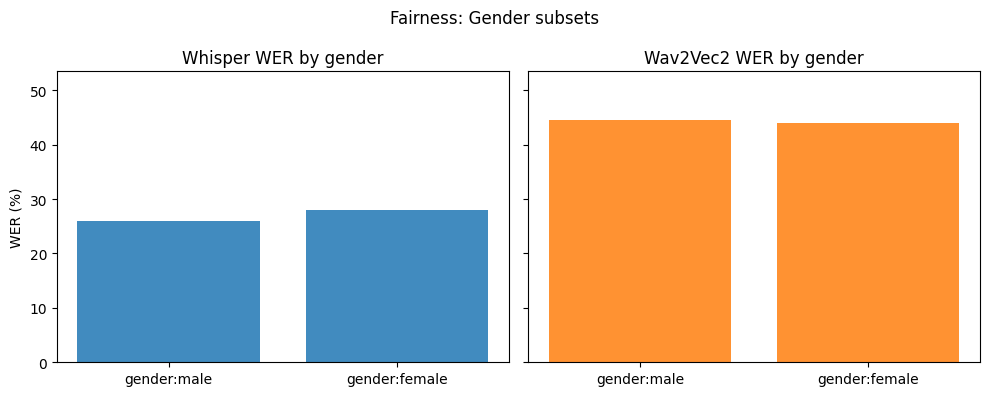

In [22]:
# --- Plot WER by gender ---

fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)

if not df_gender.empty:
    ax[0].bar(df_gender['group'], df_gender['Whisper_WER'], color="#1f77b4", alpha=0.85)
    ax[0].set_title("Whisper WER by gender")
    ax[0].set_ylabel("WER (%)")
    ax[0].set_ylim(0, max(df_gender[['Whisper_WER','Wav2Vec2_WER']].max()) * 1.2)

    ax[1].bar(df_gender['group'], df_gender['Wav2Vec2_WER'], color="#ff7f0e", alpha=0.85)
    ax[1].set_title("Wav2Vec2 WER by gender")

    plt.suptitle("Fairness: Gender subsets")
    plt.tight_layout()
else:
    plt.text(0.5,0.5,"No gender data available", ha='center')

# Save
os.makedirs("runs", exist_ok=True)
fig.savefig("runs/fairness_gender_wer.png", dpi=150)
df_gender.to_csv("runs/fairness_gender_summary.csv", index=False)
plt.show()

In [23]:
# --- Accent normalization + pick top-K accents ---

def norm_accent(x):
    if not isinstance(x, str): return "unknown"
    x = x.strip().lower()
    return x if len(x) else "unknown"

if 'accent' in meta.columns:
    meta['accent_clean'] = meta['accent'].map(norm_accent)
else:
    meta['accent_clean'] = "unknown"

# Top-K accents by count (ignore 'unknown' if you wish)
K = 5
accent_counts = (meta[meta['accent_clean']!="unknown"]
                 .groupby('accent_clean').size().sort_values(ascending=False))
top_accents = accent_counts.head(K).index.tolist()
top_accents

[]

In [26]:
print("Columns:", meta.columns.tolist())
print(meta.head(3))

Columns: ['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'locale', 'segment', 'audio_path', 'gender_clean', 'accent_clean']
                                           client_id  \
0  000abb3006b78ea4c1144e55d9d158f05a9db011016051...   
1  0013037a1d45cc33460806cc3f8ecee9d536c45639ba4c...   
2  0014c5a3e5715a54855257779b89c2bb498d470b225866...   

                           path  \
0  common_voice_en_27710027.mp3   
1    common_voice_en_699711.mp3   
2  common_voice_en_21953345.mp3   

                                            sentence  up_votes  down_votes  \
0  Joe Keaton disapproved of films, and Buster al...         3           1   
1                               She'll be all right.         2           1   
2                                                six         3           2   

   age gender accents locale    segment  \
0  NaN    NaN     NaN     en        NaN   
1  NaN    NaN     NaN     en        NaN   
2  NaN    NaN     NaN     en

In [27]:
from jiwer import wer, cer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ---- Step A: find an accent column if it exists ----
ACCENT_CANDIDATES = [
    "accent", "accents", "speaker_accent", "accent_en", "accent_clean"
]
accent_col = next((c for c in ACCENT_CANDIDATES if c in meta.columns), None)

if accent_col is None:
    print("⚠️  No accent-like column found in this dataset. Available columns:\n", meta.columns.tolist())
else:
    print(f"✅ Using accent column: {accent_col}")

    # ---- Step B: basic cleaning / normalization ----
    meta["accent_raw"] = meta[accent_col].astype(str)
    meta["accent_clean"] = (
        meta["accent_raw"]
        .str.strip()
        .str.lower()
        .replace({"nan": "", "none": ""})            # if read as string "nan"
        .replace(r"^\s*$", np.nan, regex=True)       # empty -> NaN
    )


    # ---- Step C: keeping accents with enough samples ----
    counts = meta["accent_clean"].value_counts(dropna=True)
    print("Top accents by count:\n", counts.head(20))

    MIN_SAMPLES = 80   # adjust for your slice size
    kept = counts[counts >= MIN_SAMPLES].index

    if len(kept) == 0:
        print(f"⚠️  No accent has ≥{MIN_SAMPLES} samples. Lower MIN_SAMPLES or use a bigger slice.")
    else:
        meta["accent_group"] = np.where(
            meta["accent_clean"].isin(kept), meta["accent_clean"], "other"
        )

        # meta = meta[meta["accent_group"] != "other"].copy()

        # ---- Step D: compute WER/CER per accent ----
        df_accent = meta.groupby("accent_group").apply(
            lambda g: pd.Series({
                "items": len(g),
                "Whisper_WER": wer(g["ref"].tolist(), g["hyp_whisper"].tolist()) * 100,
                "Wav2Vec2_WER": wer(g["ref"].tolist(), g["hyp_w2v"].tolist()) * 100,
                "Whisper_CER": cer(g["ref"].tolist(), g["hyp_whisper"].tolist()) * 100,
                "Wav2Vec2_CER": cer(g["ref"].tolist(), g["hyp_w2v"].tolist()) * 100,
            })
        ).reset_index()

        # Sort bars nicely (largest WER first, for example)
        df_accent = df_accent.sort_values("Wav2Vec2_WER", ascending=False)
        display(df_accent)

        # ---- Step E: plot ----
        fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

        df_accent.plot.bar(
            x="accent_group", y="Whisper_WER", ax=ax[0],
            color="#1f77b4", alpha=0.85
        )
        ax[0].set_title("Whisper WER by accent")
        ax[0].set_ylabel("WER (%)")
        ax[0].set_xlabel("Accent")

        df_accent.plot.bar(
            x="accent_group", y="Wav2Vec2_WER", ax=ax[1],
            color="#ff7f0e", alpha=0.85
        )
        ax[1].set_title("Wav2Vec2 WER by accent")
        ax[1].set_xlabel("Accent")

        plt.suptitle("Fairness: Accent subsets")
        plt.tight_layout()

        os.makedirs("runs", exist_ok=True)
        plt.savefig("runs/fairness_accent_wer.png", dpi=150)
        df_accent.to_csv("runs/fairness_accent_summary.csv", index=False)
        plt.show()
        print("✅ Saved: runs/fairness_accent_wer.png and runs/fairness_accent_summary.csv")

✅ Using accent column: accents
Top accents by count:
 accent_clean
united states english                                            389397
england english                                                  134595
india and south asia (india, pakistan, sri lanka)                101067
canadian english                                                  61132
australian english                                                51593
german english,non native speaker                                 42001
scottish english                                                  15820
new zealand english                                               12381
irish english                                                      9607
southern african (south africa, zimbabwe, namibia)                 8485
northern irish                                                     6897
filipino                                                           5173
hong kong english                                                  43

KeyError: 'ref'

In [29]:
import numpy as np
import pandas as pd

# sample must have columns: 'ref', 'hyp_whisper', 'hyp_w2v', and some accent column
ACCENT_COL = None
for c in ['accent_group', 'accents', 'accent_clean', 'accent']:
    if c in sample.columns:
        ACCENT_COL = c
        break
assert ACCENT_COL is not None, "No accent column found in sample!"

# Clean it up
sample['accent_group'] = (
    sample[ACCENT_COL]
    .fillna('unknown')
    .astype(str)
    .str.strip()
    .str.lower()
)

# (optional) Collapse very rare accents to 'other' so bars are stable
topN = 20
top_accents = (
    sample['accent_group'].value_counts()
    .head(topN)
    .index
)
sample.loc[~sample['accent_group'].isin(top_accents), 'accent_group'] = 'other'

In [31]:
# this MUST be the same frame you used when you generated hyp_whisper / hyp_w2v
df_eval = sample.copy()  # <- not the full meta; use your evaluated subset

# normalize reference text into a column used by WER/CER
def normalize_text(s: str) -> str:
    import re
    s = s.lower().strip()
    s = re.sub(r"[^a-z' ]", " ", s)   # keep letters + spaces + apostrophes
    s = re.sub(r"\s+", " ", s).strip()
    return s

df_eval["ref"] = df_eval["sentence"].astype(str).map(normalize_text)

# picking accent column present in your data
accent_col = "accents" if "accents" in df_eval.columns else "accent_clean"
print(f"✅ Using accent column: {accent_col}")

✅ Using accent column: accents


In [32]:
top_accents = (
    df_eval[accent_col].fillna("unknown").value_counts().head(20).index.tolist()
)
print("Top accents by count:\n", df_eval[accent_col].fillna("unknown").value_counts().head(20))

# creating a grouped label with "Other" for less frequent accents
df_eval["accent_group"] = np.where(
    df_eval[accent_col].isin(top_accents),
    df_eval[accent_col],
    "other"
)

Top accents by count:
 accents
unknown                                                 2348
United States English                                   1230
England English                                          414
India and South Asia (India, Pakistan, Sri Lanka)        301
Canadian English                                         176
Australian English                                       157
German English,Non native speaker                        140
Scottish English                                          47
Irish English                                             32
Southern African (South Africa, Zimbabwe, Namibia)        26
Northern Irish                                            23
New Zealand English                                       22
Filipino                                                  17
Hong Kong English                                         10
Malaysian English                                          9
Liverpool English,Lancashire English,England English  

In [36]:
print("len(sample) =", len(sample))
print("Columns in sample:", list(sample.columns))

len(sample) = 5000
Columns in sample: ['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'locale', 'segment', 'audio_path', 'accent_group']


In [37]:
EVAL_N = 64  # keep this small while iterating
df_eval = sample.head(EVAL_N).reset_index(drop=True)
paths_eval = df_eval["audio_path"].tolist()
print("Eval items:", len(paths_eval))

Eval items: 64


In [38]:
import os, json

os.makedirs("cache", exist_ok=True)
WHISP_CACHE = "cache/whisper_medium.json"
W2V_CACHE   = "cache/wav2vec2_large.json"

def _load_cache(path):
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return {}

def _save_cache(path, data):
    tmp = path + ".tmp"
    with open(tmp, "w") as f:
        json.dump(data, f, ensure_ascii=False)
    os.replace(tmp, path)

whisp_cache = _load_cache(WHISP_CACHE)   # {audio_path: text}
w2v_cache   = _load_cache(W2V_CACHE)

In [39]:
import torch, torchaudio, numpy as np
from torch.nn.utils.rnn import pad_sequence
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def load_w2v():
    model_id = "facebook/wav2vec2-large-960h-lv60-self"
    proc = Wav2Vec2Processor.from_pretrained(model_id)
    mdl  = Wav2Vec2ForCTC.from_pretrained(model_id).to(DEVICE).eval()
    return proc, mdl

w2v_proc, w2v_model = load_w2v()

def _load_wave_16k(path):
    wav, sr = torchaudio.load(path)
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    # mono
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    return wav.squeeze(0)  # [T]

def transcribe_w2v_missing(paths, batch_size=16):
    new = {}
    todo = [p for p in paths if p not in w2v_cache]
    if not todo:
        return new

    print(f"[W2V] transcribing {len(todo)} missing items...")
    for i in range(0, len(todo), batch_size):
        batch = todo[i:i+batch_size]
        waves = [ _load_wave_16k(p) for p in batch ]
        lens  = [ w.numel() for w in waves ]
        padded = pad_sequence(waves, batch_first=True)
        inputs = w2v_proc(padded, sampling_rate=16000, return_tensors="pt", padding=True).to(DEVICE)

        with torch.inference_mode():
            logits = w2v_model(**inputs).logits
            pred_ids = torch.argmax(logits, dim=-1)
            texts = w2v_proc.batch_decode(pred_ids, skip_special_tokens=True)

        # normalize & store
        texts = [t.lower().strip() for t in texts]
        for p,t in zip(batch, texts):
            w2v_cache[p] = t
            new[p] = t

        _save_cache(W2V_CACHE, w2v_cache)
        print(f"  [W2V] {i+len(batch)}/{len(todo)}")
    return new

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

def load_whisper():
    model_id = "openai/whisper-small.en"  # MUCH faster than "medium" on CPU
    proc = WhisperProcessor.from_pretrained(model_id)
    mdl  = WhisperForConditionalGeneration.from_pretrained(model_id).to(DEVICE).eval()
    return proc, mdl

whisp_proc, whisp_model = load_whisper()

GEN_KW = dict(
    task="transcribe",
    language="en",
    num_beams=1,
    no_repeat_ngram_size=0,
    temperature=0.0,
)

def transcribe_whisper_missing(paths):
    new = {}
    todo = [p for p in paths if p not in whisp_cache]
    if not todo:
        return new

    print(f"[Whisper] transcribing {len(todo)} missing items...")
    for i,p in enumerate(todo, 1):
        # load + log-mel
        wav, sr = torchaudio.load(p)
        if sr != 16000:
            wav = torchaudio.functional.resample(wav, sr, 16000)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        features = whisp_proc(wav.squeeze(0).numpy(), sampling_rate=16000, return_tensors="pt").to(DEVICE)

        with torch.inference_mode():
            ids = whisp_model.generate(features["input_features"], **GEN_KW)
            text = whisp_proc.batch_decode(ids, skip_special_tokens=True)[0]

        text = text.lower().strip()
        whisp_cache[p] = text
        new[p] = text

        if i % 5 == 0 or i == len(todo):
            _save_cache(WHISP_CACHE, whisp_cache)
        if i % 10 == 0 or i == len(todo):
            print(f"  [Whisper] {i}/{len(todo)}")
    return new

python(87680) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

In [44]:
# basics used by the helper
import numpy as np, torch, librosa

DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_SR  = 16000            # wav2vec2 expects 16 kHz
WHISPER_SR = 16000            # Whisper also uses 16 kHz input

# need these to define the function again for the transcribe to work
w2v_proc  = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h-lv60-self")
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h-lv60-self").to(DEVICE).eval()

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
import numpy as np, librosa, torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# 1) Model + processor
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
WHISPER_ID = "openai/whisper-medium"  # change if using an .en model
WHISPER_SR = 16000

wh_proc  = WhisperProcessor.from_pretrained(WHISPER_ID)
wh_model = WhisperForConditionalGeneration.from_pretrained(WHISPER_ID).to(DEVICE).eval()

# 2) Detect English-only vs multilingual and set flags properly
IS_EN_ONLY = WHISPER_ID.endswith(".en")
if IS_EN_ONLY:
    # English-only
    GEN_KW      = {}         # nothing
    FORCED_IDS  = None
    wh_model.generation_config.is_multilingual = False
else:
    # Multilingual: pass task/language and force decoder ids
    GEN_KW      = dict(task="transcribe", language="en")
    FORCED_IDS  = wh_proc.get_decoder_prompt_ids(**GEN_KW)
    wh_model.generation_config.is_multilingual = True

# 3) Load a few WAVs to test (1-D float32, 16 kHz)
def load_wavs(paths, sr=WHISPER_SR):
    out = []
    for p in paths:
        y, _ = librosa.load(p, sr=sr, mono=True)
        out.append(y.astype(np.float32))
    return out

# e.g., pick test paths
test_paths = [
    df_eval["audio_path"].iloc[0],  # or df/sample you already built
    # df_eval["audio_path"].iloc[1],
]

wavs = load_wavs(test_paths, sr=WHISPER_SR)

# 4) Run Whisper
with torch.no_grad():
    inputs = wh_proc(wavs, sampling_rate=WHISPER_SR, return_tensors="pt").to(DEVICE)
    feats  = inputs["input_features"]
    pred   = wh_model.generate(
        feats,
        forced_decoder_ids=FORCED_IDS,  # None for .en models
        **GEN_KW                           # {} for .en models
    )
    texts  = wh_proc.batch_decode(pred, skip_special_tokens=True)

print("OK:", texts)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


OK: [' They are indigenous and peace loving community.']


In [54]:
def transcribe_whisper_missing(paths,
                               batch_size=8,
                               device=DEVICE,
                               wh_proc=wh_proc,
                               wh_model=wh_model,
                               sr=16000):
    """
    Transcribe wav paths with Whisper, auto-handling EN-only vs multilingual models.
    - Do NOT pass task/lang for EN-only models.
    - Set proper flags / forced ids for multilingual models.
    """

    out_texts = []
    # --- Deciding generation kwargs based on the *current* model -------------
    # Heuristics: .en checkpoints OR config says not multilingual
    is_en_only = False
    try:
        # adding wisper id:
        is_en_only = (('WHISPER_ID' in globals() and str(WHISPER_ID).endswith('.en'))
                      or not getattr(wh_model.generation_config, "is_multilingual", True))
    except Exception:
        # fall back to config flag only
        is_en_only = not getattr(wh_model.generation_config, "is_multilingual", True)

    if is_en_only:
        # English-only: do not pass task/language
        GEN_KW = {}
        FORCED_IDS = None
        wh_model.generation_config.is_multilingual = False
    else:
        # Multilingual: set task/lang, force the decoder prompt, ensuring flag is true
        GEN_KW = dict(task="transcribe", language="en")
        FORCED_IDS = wh_proc.get_decoder_prompt_ids(task="transcribe", language="en")
        wh_model.generation_config.is_multilingual = True
    # -----------------------------------------------------------------------

    # batched forward
    for i in range(0, len(paths), batch_size):
        batch = paths[i:i+batch_size]

        # load audio -> 1-D float32 @ 16 kHz
        wavs = []
        for p in batch:
            y, sr_in = librosa.load(p, sr=sr, mono=True)
            wavs.append(y.astype(np.float32))
        # safety: every item must be 1-D
        assert all(np.ndim(w) == 1 for w in wavs), "each wav must be 1-D"

        # processor makes log-mels, pads & stacks
        inputs = wh_proc(
            wavs,
            sampling_rate=sr,
            return_tensors="pt",
            padding=True
        ).to(device)

        with torch.no_grad():
            feats = inputs["input_features"]                     # [B, 80, T']
            pred_ids = wh_model.generate(
                feats,
                forced_decoder_ids=FORCED_IDS,
                **GEN_KW
            )
            texts = wh_proc.batch_decode(pred_ids, skip_special_tokens=True)

        out_texts.extend(t.strip() for t in texts)

    return out_texts

In [55]:
def transcribe_whisper_paths(paths, whisper_id="openai/whisper-medium", batch_size=8, device=None):
    import numpy as np, librosa, torch
    from transformers import WhisperProcessor, WhisperForConditionalGeneration

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    sr = 16000

    proc  = WhisperProcessor.from_pretrained(whisper_id)
    model = WhisperForConditionalGeneration.from_pretrained(whisper_id).to(device).eval()

    is_en = whisper_id.endswith(".en")
    if is_en:
        gen_kw = {}
        forced_ids = None
        model.generation_config.is_multilingual = False
    else:
        gen_kw = dict(task="transcribe", language="en")
        forced_ids = proc.get_decoder_prompt_ids(**gen_kw)
        model.generation_config.is_multilingual = True

    out = []
    for i in range(0, len(paths), batch_size):
        chunk = paths[i:i+batch_size]
        wavs = []
        for p in chunk:
            y, _ = librosa.load(p, sr=sr, mono=True)
            wavs.append(y.astype(np.float32))

        with torch.no_grad():
            inputs = proc(wavs, sampling_rate=sr, return_tensors="pt").to(device)
            feats  = inputs["input_features"]
            ids    = model.generate(feats, forced_decoder_ids=forced_ids, **gen_kw)
            out.extend(proc.batch_decode(ids, skip_special_tokens=True))
    return out

In [56]:
# Detect whether we loaded an English-only Whisper or a multilingual one
IS_EN_ONLY = WHISPER_ID.endswith(".en")

if IS_EN_ONLY:
    # English-only model
    GEN_KW = {}
    FORCED_IDS = None
    # Make sure generation config reflects English-only
    wh_model.generation_config.is_multilingual = False
else:
    # Multilingual model
    GEN_KW = dict(task="transcribe", language="en")
    FORCED_IDS = wh_proc.get_decoder_prompt_ids(**GEN_KW)
    wh_model.generation_config.is_multilingual = True

In [57]:
with torch.no_grad():
    inputs = wh_proc(wavs, sampling_rate=16000, return_tensors="pt", padding=True).to(DEVICE)
    input_features = inputs["input_features"]

    pred_ids = wh_model.generate(
        input_features,
        forced_decoder_ids=FORCED_IDS,
        **GEN_KW  # will be {} for .en models, or {task, language} for multilingual
    )
    texts = wh_proc.batch_decode(pred_ids, skip_special_tokens=True)

In [59]:
missing_w2v   = [p for p in paths_eval if p not in w2v_cache]
missing_whisp = [p for p in paths_eval if p not in whisp_cache]

print("Missing in w2v_cache:",   len(missing_w2v))
print("Missing in whisp_cache:", len(missing_whisp))

# couple examples:
print("w2v examples:",   missing_w2v[:3])
print("whisp examples:", missing_whisp[:3])

Missing in w2v_cache: 64
Missing in whisp_cache: 64
w2v examples: ['/Users/ninadjoshi/asr-comparative-study/ASR-Comparative-Study-Thesis/asr-comparative-study/notebooks/data/cv11_en/cv-corpus-11.0-2022-09-21/en/clips/common_voice_en_21940789.mp3', '/Users/ninadjoshi/asr-comparative-study/ASR-Comparative-Study-Thesis/asr-comparative-study/notebooks/data/cv11_en/cv-corpus-11.0-2022-09-21/en/clips/common_voice_en_23332171.mp3', '/Users/ninadjoshi/asr-comparative-study/ASR-Comparative-Study-Thesis/asr-comparative-study/notebooks/data/cv11_en/cv-corpus-11.0-2022-09-21/en/clips/common_voice_en_100999.mp3']
whisp examples: ['/Users/ninadjoshi/asr-comparative-study/ASR-Comparative-Study-Thesis/asr-comparative-study/notebooks/data/cv11_en/cv-corpus-11.0-2022-09-21/en/clips/common_voice_en_21940789.mp3', '/Users/ninadjoshi/asr-comparative-study/ASR-Comparative-Study-Thesis/asr-comparative-study/notebooks/data/cv11_en/cv-corpus-11.0-2022-09-21/en/clips/common_voice_en_23332171.mp3', '/Users/ninad

In [60]:
def transcribe_w2v_missing(paths, batch_size=16):
    todo = [p for p in paths if p not in w2v_cache]
    if not todo:
        return
    out_texts = []
    for i in range(0, len(todo), batch_size):
        batch = todo[i:i+batch_size]
        wavs = []
        for p in batch:
            y, sr = librosa.load(p, sr=TARGET_SR, mono=True)
            wavs.append(y.astype(np.float32))
        assert all(np.ndim(w)==1 for w in wavs)  # must be 1-D
        inputs = w2v_proc(wavs, sampling_rate=TARGET_SR, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            logits  = w2v_model(**inputs).logits
            pred_ids = torch.argmax(logits, dim=-1)
            texts = w2v_proc.batch_decode(pred_ids, skip_special_tokens=True)
        out_texts.extend([t.lower().strip() for t in texts])
    for p, t in zip(todo, out_texts):
        w2v_cache[p] = t

def transcribe_whisper_missing(paths, batch_size=8):
    todo = [p for p in paths if p not in whisp_cache]
    if not todo:
        return
    out_texts = []
    for i in range(0, len(todo), batch_size):
        batch = todo[i:i+batch_size]
        wavs = [librosa.load(p, sr=WHISPER_SR, mono=True)[0] for p in batch]
        feats = wh_proc(np.vstack([w[np.newaxis,:] for w in wavs]), sampling_rate=WHISPER_SR, return_tensors="pt").to(device)

        # IMPORTANT: English-only vs multilingual guard you already added:
        if IS_EN_ONLY:
            gen_ids = wh_model.generate(feats["input_features"])
        else:
            gen_ids = wh_model.generate(
                feats["input_features"],
                **GEN_KW,
                forced_decoder_ids=FORCED_IDS
            )

        texts = wh_proc.batch_decode(gen_ids, skip_special_tokens=True)
        out_texts.extend([t.lower().strip() for t in texts])
    for p, t in zip(todo, out_texts):
        whisp_cache[p] = t

In [61]:
# 1) finding what’s missing
missing_w2v   = [p for p in paths_eval if p not in w2v_cache]
missing_whisp = [p for p in paths_eval if p not in whisp_cache]
print(len(missing_w2v), "missing w2v; ", len(missing_whisp), "missing whisper")

# 2) filling only the gaps
transcribe_w2v_missing(paths_eval)
transcribe_whisper_missing(paths_eval)

# 3) rebuilding for safety
hyp_w2v     = [w2v_cache[p]   for p in paths_eval]
hyp_whisper = [whisp_cache[p] for p in paths_eval]
assert len(paths_eval) == len(hyp_whisper) == len(hyp_w2v)

64 missing w2v;  64 missing whisper


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 66432 and the array at index 1 has size 145536

In [62]:
_ = transcribe_w2v_missing(paths_eval)       # fills w2v_cache incrementally
_ = transcribe_whisper_missing(paths_eval)   # fills whisp_cache incrementally

# Build lists in the same order as df_eval
hyp_w2v     = [ w2v_cache[p]   for p in paths_eval ]
hyp_whisper = [ whisp_cache[p] for p in paths_eval ]

print("Lengths:",
      len(paths_eval), len(hyp_whisper), len(hyp_w2v))
assert len(paths_eval) == len(hyp_whisper) == len(hyp_w2v)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 66432 and the array at index 1 has size 145536

## Noise Robustness Testing

In [64]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, WhisperForConditionalGeneration, WhisperProcessor
import torch

# Load Wav2Vec2 (English pretrained)
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
w2v_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
w2v_model.to("cuda" if torch.cuda.is_available() else "cpu")

# Load Whisper (small English model as example)
whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-small")
whisper_model.to("cuda" if torch.cuda.is_available() else "cpu")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (f

In [65]:
models = {
    "Whisper": (whisper_model, whisper_processor),
    "Wav2Vec": (w2v_model, w2v_processor),
}

In [66]:
import numpy as np
import librosa
import soundfile as sf

def add_noise(audio, snr_db):
    """
    Add Gaussian noise to an audio signal at a specified SNR.
    :param audio: numpy array of audio samples
    :param snr_db: desired SNR in dB (higher = cleaner, lower = noisier)
    :return: noisy audio array
    """
    signal_power = np.mean(audio**2)
    snr_linear = 10 ** (snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power), audio.shape)
    return audio + noise

In [67]:
from jiwer import wer

def evaluate_model_on_noise(model, processor, audio_path, transcript, snr_levels=[20, 10, 0]):
    results = {}
    audio, sr = librosa.load(audio_path, sr=16000)

    # Clean
    inputs = processor(audio, sampling_rate=sr, return_tensors="pt").to(model.device)
    with torch.no_grad():
        logits = model(inputs.input_values).logits
    pred_ids = torch.argmax(logits, dim=-1)
    prediction = processor.batch_decode(pred_ids)[0].lower()
    results["clean"] = {"prediction": prediction, "wer": wer(transcript.lower(), prediction)}

    # Noisy
    for snr in snr_levels:
        noisy_audio = add_noise(audio, snr_db=snr)
        inputs = processor(noisy_audio, sampling_rate=sr, return_tensors="pt").to(model.device)
        with torch.no_grad():
            logits = model(inputs.input_values).logits
        pred_ids = torch.argmax(logits, dim=-1)
        prediction = processor.batch_decode(pred_ids)[0].lower()
        results[f"{snr}dB"] = {"prediction": prediction, "wer": wer(transcript.lower(), prediction)}

    return results

In [75]:
!tar -tvf cv-corpus-11.0-2022-09-21-en.tar.gz | head -n 50

drwxrwxr-x  0 1000   1000        0 13 Dec  2020 cv-corpus-11.0-2022-09-21/en/
drwxrwxr-x  0 1000   1000        0 16 Sep  2022 cv-corpus-11.0-2022-09-21/en/clips/
-rw-r--r--  0 1000   1000  3790336 16 Sep  2022 cv-corpus-11.0-2022-09-21/en/dev.tsv


python(90652) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


-rw-r--r--  0 1000   1000 62313406 16 Sep  2022 cv-corpus-11.0-2022-09-21/en/invalidated.tsv
-rw-r--r--  0 1000   1000 69533545 16 Sep  2022 cv-corpus-11.0-2022-09-21/en/other.tsv
-rw-rw-r--  0 1000   1000   648609 17 Sep  2022 cv-corpus-11.0-2022-09-21/en/reported.tsv
-rw-r--r--  0 1000   1000  3734423 16 Sep  2022 cv-corpus-11.0-2022-09-21/en/test.tsv
-rw-r--r--  0 1000   1000 243129933 16 Sep  2022 cv-corpus-11.0-2022-09-21/en/train.tsv
-rw-r--r--  0 1000   1000 396703049 16 Sep  2022 cv-corpus-11.0-2022-09-21/en/validated.tsv
-rw-rw-r--  0 1000   1000     18017 10 Dec  2020 cv-corpus-11.0-2022-09-21/en/clips/common_voice_en_1.mp3
-rw-rw-r--  0 1000   1000     17633 10 Dec  2020 cv-corpus-11.0-2022-09-21/en/clips/common_voice_en_10.mp3
-rw-rw-r--  0 1000   1000     23969 10 Dec  2020 cv-corpus-11.0-2022-09-21/en/clips/common_voice_en_100.mp3
-rw-rw-r--  0 1000   1000     94113 10 Dec  2020 cv-corpus-11.0-2022-09-21/en/clips/common_voice_en_1000.mp3
-rw-rw-r--  0 1000   1000     3766

In [80]:
import pandas as pd, os

base_dir = "./common_voice_subset/cv-corpus-11.0-2022-09-21/en"

df = pd.read_csv(os.path.join(base_dir, "test.tsv"), sep="\t")

test_samples = []
for _, row in df.head(5).iterrows():
    audio_path = os.path.join(base_dir, "clips", row["path"])
    transcript = row["sentence"]
    test_samples.append((audio_path, transcript))

print(test_samples)

FileNotFoundError: [Errno 2] No such file or directory: './common_voice_subset/cv-corpus-11.0-2022-09-21/en/test.tsv'

## Resource Analysis

In [81]:
import time, librosa, torch

def measure_rtf(model, processor, audio_path, device="cpu"):
    # Load audio
    audio, sr = librosa.load(audio_path, sr=16000)
    duration = len(audio) / sr
    
    # Prepare input
    inputs = processor(audio, sampling_rate=sr, return_tensors="pt").to(device)
    
    # Time inference
    start = time.time()
    with torch.no_grad():
        _ = model(inputs.input_values).logits
    end = time.time()
    
    return (end - start) / duration  # RTF

In [82]:
import psutil

def get_cpu_memory():
    process = psutil.Process()
    mem = process.memory_info().rss / 1024**2  # MB
    return f"{mem:.2f} MB"

In [83]:
def get_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**2
        reserved = torch.cuda.memory_reserved() / 1024**2
        return f"Allocated {allocated:.2f} MB / Reserved {reserved:.2f} MB"
    return "No GPU available"

In [104]:
base_dir = "common_voice_subset/cv-corpus-11.0-2022-09-21/en"

In [106]:
test_audio = "common_voice_subset/cv-corpus-11.0-2022-09-21/en/clips/common_voice_en_100001.mp3"
print("Using:", test_audio)

Using: common_voice_subset/cv-corpus-11.0-2022-09-21/en/clips/common_voice_en_100001.mp3


In [108]:
import librosa, time, torch

def measure_rtf(model, processor, audio_path, device="cpu"):
    audio, sr = librosa.load(audio_path, sr=16000)
    duration = len(audio) / sr

    # Preprocess depending on model type
    inputs = processor(audio, sampling_rate=sr, return_tensors="pt")

    if "input_values" in inputs:   # Wav2Vec2
        inputs = inputs.to(device)
        start = time.time()
        with torch.no_grad():
            _ = model(inputs.input_values).logits
        end = time.time()

    elif "input_features" in inputs:  # Whisper
        inputs = inputs.to(device)
        start = time.time()
        with torch.no_grad():
            _ = model.generate(inputs.input_features)
        end = time.time()

    else:
        raise ValueError("Unknown model input format")

    return (end - start) / duration

In [109]:
deploy_df = benchmark_models(models, test_audio)
print(deploy_df)

Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.


     model device       rtf      memory
0  Whisper    cpu  1.334538  1290.97 MB
1  Whisper    cpu  0.477118  1325.81 MB
2  Wav2Vec    cpu  0.316746  1750.34 MB
3  Wav2Vec    cpu  0.037239  1756.44 MB


In [110]:
def benchmark_avg(models, audio_files):
    records = []
    for model_name, (model, processor) in models.items():
        for device in ["cpu", "cuda" if torch.cuda.is_available() else "cpu"]:
            model.to(device)
            rtfs = []
            for audio in audio_files:
                rtf = measure_rtf(model, processor, audio, device=device)
                rtfs.append(rtf)
            mem = get_gpu_memory() if device=="cuda" else get_cpu_memory()
            records.append({
                "model": model_name,
                "device": device,
                "avg_rtf": sum(rtfs)/len(rtfs),
                "memory": mem
            })
    return pd.DataFrame(records)

# Example usage with first 5 clips
import glob
audio_files = glob.glob("common_voice_subset/cv-corpus-11.0-2022-09-21/en/clips/*.mp3")[:5]
deploy_df = benchmark_avg(models, audio_files)
print(deploy_df)

     model device   avg_rtf      memory
0  Whisper    cpu  0.789478  1730.75 MB
1  Whisper    cpu  0.602564  1677.31 MB
2  Wav2Vec    cpu  0.078241  1746.92 MB
3  Wav2Vec    cpu  0.038054  1748.03 MB
